# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 0. Численное моделирование случайных величин. Графическая интерпретация результатов
### Дедлайн --- 21 сентября 23:59

Это первое обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

In [1]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 9.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.3
    Uninstalling statsmodels-0.14.3:
      Successfully uninstalled statsmodels-0.14.3

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

**Зафиксируем** `seed` для воспроизводимости.

In [4]:
np.random.seed(42)



```
# Выбран кодовый формат
```

**Условие задания**: Во всех домашних заданиях практики по статистике Вы будете видеть ключевое слово "промоделируйте" и требование построить график с целью проверки некоторых свойств. В этом домашнем задании мы предлагаем Вам потренировать эти навыки на модельных примерах.

**Гайд, как моделировать оценки**:

Если Вам неизвестно слово "оценка", то всюду считайте, что это случайная величина $\theta = \theta(X_1, ..., X_n)$, где $X_i$ --- одинаково распределённые элементы из некоторого распределения. Позже на лекции термин "оценка" введут строго.

Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить эмпирическую плотность, и на её основе делать какие-то выводы.

Условие домашки.

Аспект-император (тот самый) Анасуримбор Келлхус отдал приказ готовить великую ордалию к походу на север --- в цитадель хаотичного зла. Так как путь пройдёт через кишащие чудовищами голодные пустоши, то путешествие должно быть тщательно спланировано, чтобы армия дошла в полном составе.

Для этого имперские математики моделируют всевозможные проблемы и их решения, чтобы предотвратить потенциальные трудности. На севере никто никогда не был, никто никогда с него не возращался, так что прямого доступа к законам природы севера нет. Однако, есть некоторые догадки и результаты экспериментов, распределения, которые Вы можете генерировать из коробки.

Убедите Аспект-Императора в том, что Вы умеете правильно считать сложные величины и проверять сложные закономерности.

### Задача 1

В данной задаче Вы научитесь численно получать значения из сложных распределений на примере распределения Фишера.

Нашей финальной целью будет промоделировать распределение Фишера и получить точные оценки его мат. ожидания и дисперсии.

**Внимание!**

В рамках данной задачи разрешено генерировать только нормально распределённые величины. Остальные можно получать из них.

Распределение Фишера с степенями свободы $(d_1, d_2)$ представляет собой распределение следующей случайной величины: $F \stackrel{d}{=} \frac{Y_1/d_1}{Y_2/d_2}$, где $Y_i$ --- величина из распределения хи-квадрат со степенью свободы $d_i$, то есть  $Y_i \stackrel{d}{=} \sum\limits_{j = 1}^{d_i} X_{i, j}^2$, где $X_{i, 1}, \ldots, X_{i, d_i}$ независимы и взяты из стандартного нормального распределения.

Распределение Фишера является предельным распределением для построения множества гипотез в статистике, так что его сэмплирование представляет собой важную задачу для численного анализа (и принятия решений).

От распределения Фишера нам нужно две вещи: плотность распределения (для изучения его поведения) и количественные свойства (моменты, для примера).

Фишер вывел формулу плотности распределения аналитически, так что процесс сэмплирования можно проводить одношагово, но это не наш путь. Мы будем получать плотность при помощи KDE, считая её неизвестной (как происходит на практике для величин, плотности которых у нас нет).

Для этого нам нужно получить выборку из распределения Фишера размером хотя бы $N = 1000$ или больше.

Сгенерируйте такую выборку, используя формулы выше. В качестве степеней свободы возьмите значения $d_1 = 5$, $d_2 = 7$. Не забудьте, что элементы выборки должны быть не только одинаково распределёнными, но и независимыми в совокупности.

In [28]:
SAMPLE_NUM = 10000
d_1 = 5
d_2 = 7

In [29]:
sample = sps.f.rvs(dfn=d_1, dfd=d_2, size=SAMPLE_NUM)

Вспомните, как работает KDE для вычисления плотности по выборке. Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Постройте в одних осях KDE по Вашей выборке и теоретическую плотность [распределения Фишера](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html), взятую из scipy.

10000


[]

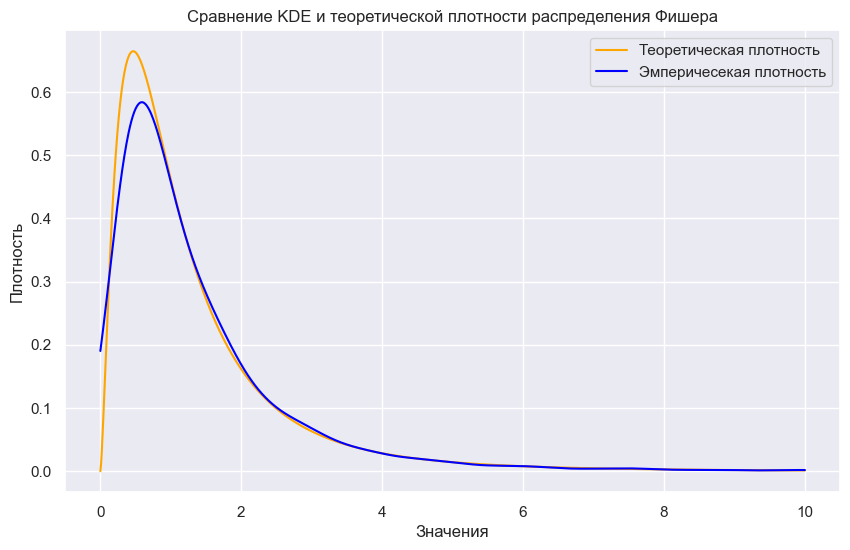

In [38]:
plt.figure(figsize=(10, 6))

x = np.linspace(0, 10, 1000)
pdf = sps.f.pdf(x, 5, 7)

print(sample.size)

kernel = sps.gaussian_kde(np.array(sample))
plt.plot(x, pdf, label='Теоретическая плотность', color='orange')
plt.plot(x, kernel(x), label='Эмперичесекая плотность', color='blue')

plt.title('Сравнение KDE и теоретической плотности распределения Фишера')
plt.xlabel('Значения')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.plot()


Похожи ли графики? О чём это говорит?

Ответ: KDE хорошо приближает плотность Фишера при достаточно больших выборках

Посмотрите на поведение KDE для разных размеров выборки. Рекомендуем брать не более трёх вариантов, чтобы не захламлять график, возьмите значения как больше, так и меньше изначального $N$ (особенно если ячейки долго работают). Как меняется вид оценки?

In [67]:
sample1 = np.random.f(5, 7, 5000)
sample2 = np.random.f(5, 7, 1000)
sample3 = np.random.f(5, 7, 200)

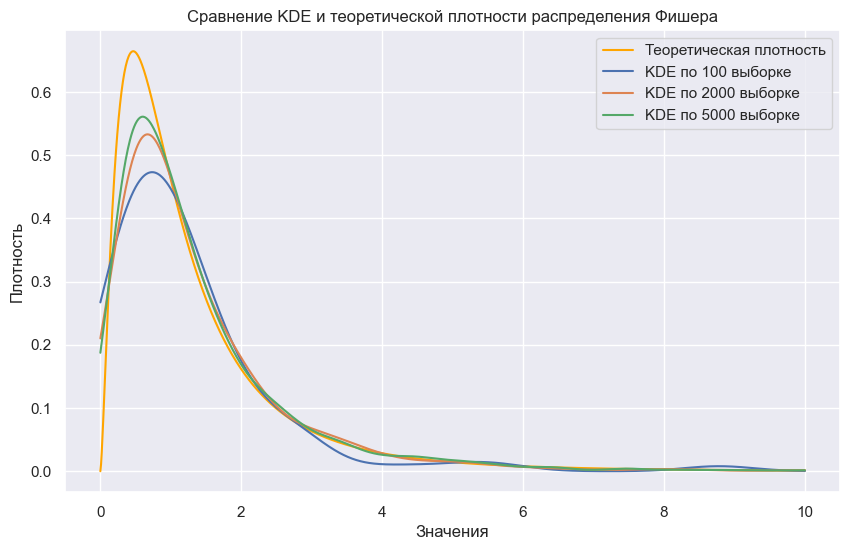

In [37]:
x = np.linspace(0, 10, 1000)
pdf = sps.f.pdf(x, 5, 7)

plt.figure(figsize=(10, 6))

kernel1 = sps.gaussian_kde(sps.f.rvs(d_1, d_2, size=100))
kernel2 = sps.gaussian_kde(sps.f.rvs(d_1, d_2, size=2000))
kernel3 = sps.gaussian_kde(sps.f.rvs(d_1, d_2, size=5000))


plt.plot(x, pdf, label='Теоретическая плотность', color='orange')
plt.plot(x, kernel1(x), label='KDE по 100 выборке')
plt.plot(x, kernel2(x), label='KDE по 2000 выборке')
plt.plot(x, kernel3(x), label='KDE по 5000 выборке')


plt.title('Сравнение KDE и теоретической плотности распределения Фишера')
plt.xlabel('Значения')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

Используя первоначальную выборку, посчитайте мат. ожидание и дисперсию распределения Фишера. Посчитайте теоретически мат. ожидание и дисперсию (формулы есть на Википедии). Сравните результаты.

In [36]:
np_mat_exp = np.mean(sample)
np_disp = np.mean(sample**2) - np.mean(sample)**2

mat_exp = float(np_mat_exp)
disp = float(np_disp)

print("Значения выборок:")
print(f"мат.ожидание = {round(mat_exp, 2)}")
print(f"дисперсия = {round(disp, 2)}")

print("В то время как у реального рапределения:")
print(f"мат.ожидание = {1.4}")
print(f"дисперсия = {2.61}")

Значения выборок:
мат.ожидание = 1.39
дисперсия = 2.47
В то время как у реального рапределения:
мат.ожидание = 1.4
дисперсия = 2.61


Проверьте, что с ростом $N$ эмпирические мат. ожидание и дисперсия сходятся к теоретическим. Сделайте выводы.

In [70]:
np_mat_exp1 = np.mean(sample1)
np_mat_exp2 = np.mean(sample2)
np_mat_exp3 = np.mean(sample3)

np_disp1 = np.mean(sample1**2) - np.mean(sample1)**2
np_disp2 = np.mean(sample2**2) - np.mean(sample2)**2
np_disp3 = np.mean(sample3**2) - np.mean(sample3)**2

mat_exp1 = float(np_mat_exp1)
mat_exp2 = float(np_mat_exp2)
mat_exp3 = float(np_mat_exp3)

disp1 = float(np_disp1)
disp2 = float(np_disp2)
disp3 = float(np_disp3)

print(f"При N=200 {(mat_exp3, disp3)}")
print(f"При N=1000 {(mat_exp2, disp2)}")
print(f"При N=5000 {(mat_exp1, disp1)}")


При N=200 (1.568660333438932, 2.0164224401448183)
При N=1000 (1.5012989937457344, 4.117373963569072)
При N=5000 (1.3813760637470553, 2.2898863616747382)


Вспомните, как работает QQ-plot.

Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

QQ-plot является хорошим прикладным инструментом проверки распределения на принадлежность семейству. Проверьте, что Ваша выборка действительно является выборкой из распределения Фишера, построив QQ-plot

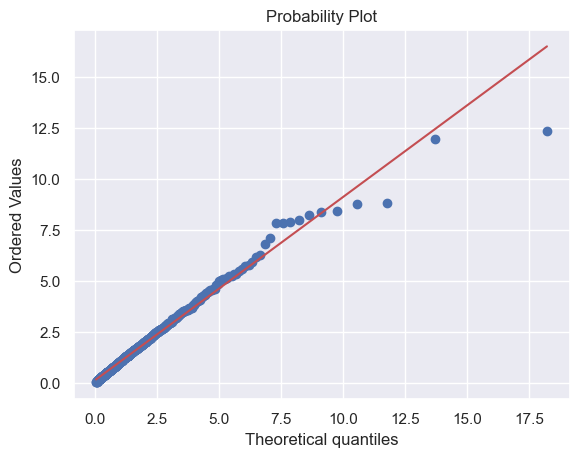

In [52]:
sps.probplot(sample, dist=sps.f(5, 7), plot=plt)
plt.show()

Какие выводы можно сделать, если точки в хвостах QQ-plot находятся выше/ниже своей прямой, как на картинке ниже? А если оба "хвоста" находятся с одной стороны прямой?

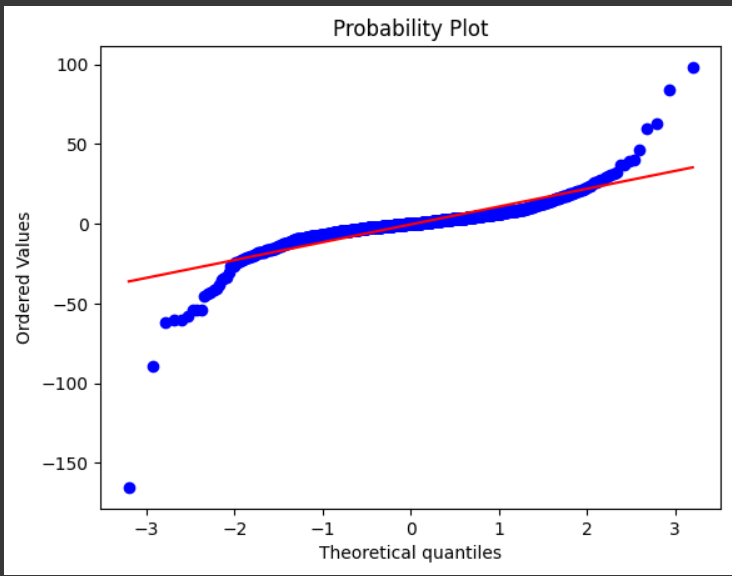

Ответ:

### Задача 2

В данной задаче Вам предстоит проверить истинность дельта-метода на практике, используя KDE.

Формулировка теоремы о дельта-методе представлена в методичке курса, глава 1, теорема 1.4.

Нас же интересует задача 3 из списка задач для самостоятельного решения.

####Условие.
Дана выборка $X_i$ из $N(0, \sigma^2)$,

$Y = \frac{1}{n}\sum_1^n |X_i|$,

$Z = \frac{1}{n}\sum_1^n X_i^2$.

$T = \sqrt{\frac{2}{\pi}}\frac{Z}{Y}$. Куда сходится $P = \sqrt{n}(T - \sigma)$ по распределению?

Скорее всего, Вы решали эту задачу на семинаре. Или решал Ваш сосед по комнате. В любом случае, известно, что предел --- это нормальное распределение с нулевым средним. Посчитайте дисперсию предельного распределения и напишите ответ ниже.

Ответ: $\sigma^2(\frac{\pi}{2} - 1)$

Теперь попробуем увидеть, как ведёт себя величина $T$ и проверить, что она сходится по распределению.

Наш план:

1) Построить выборку независимых величин $P$.

2) Построить хорошее приближение плотности $P$ для каждого $n$.

3) Изучить, как ведёт себя плотность с ростом $n$.

4) Сделать вывод о наличии сходимости по распределению к величине с заданной плотностью.

Рекомендуем Вам изначально зафиксировать несколько вариантов $\sigma$ и проводить параллельное решение каждого пункта задачи для каждого значения.

In [139]:
sigma = 1
n = 10

1) Необходимо построить выборку из величин $P$.

Каждая величина $P$ не может быть сгенерирована напрямую, так что необходимо сгенерировать выборку величин $X_i$ --- по $n$ штук для каждого $P$. Так мы приходим к понятию "выборка выборок".

Сгенерируйте N выборок $X_1, \dots, X_N$ из нормального распределения $N(0, \sigma^2)$ для $N = 10^4$. Если у Вас долго считаются формулы, можете понизить $N$ до 100. Не забывайте про векторные вычисление numpy!

In [143]:
dim1 = 10000
dim2 = 10000
matrix = np.random.normal(0, sigma**2, (dim1, dim2))

Для всех $N$ выборок посчитайте $P$.

__Подсказка:__ Могут быть полезными функции `np.arange`, `np.cumsum`, `np.maximum.accumulate` и `np.minimum.accumulate`

In [144]:
Y_val_sample = np.mean(np.abs(matrix), axis=1)
Z_val_sample = np.mean(matrix**2, axis=1)

T_val_sample = np.sqrt(2/np.pi) * (Z_val_sample / Y_val_sample)
P_val_sample = np.sqrt(dim2) * (T_val_sample - sigma)


2) Построить приближение плотности величин $P$.

Вспомните, как работает KDE для вычисления плотности по выборке.
Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Постройте график плотности выборки величин $P$. Не забудьте про оси графика!

<Axes: ylabel='Density'>

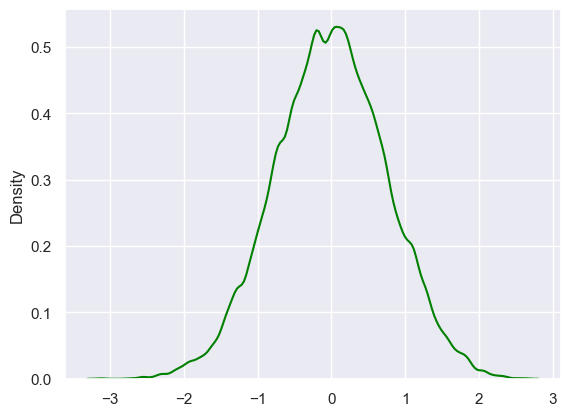

In [145]:
sns.kdeplot(P_val_sample, bw_adjust=0.5, label='KDE по выборке величин P', color='green')

3) Изучить поведение плотности с ростом $n$.

Как мы знаем из курса теории вероятностей, сходимость по распределению эквивалентна поточечной сходимости функций распределения. Теория из мат. анализа гарантирует сходимость функций при наличии сходимости их производных при выполнении некоторых других регулярных условий (см. курс мат. анализа). На практике выводы о наличии сходимости по распределению делаются при помощи демонстрации сходимости плотностей.

На одном графике изобразите жирной линией одного цвета плотность предельного распределения, посчитанного в пункте 1. Не считайте плотность нормального распределения руками, вместо этого используйте scipy.

В тех же осях изобразите полупрозрачными линиями плотности величин P для N = 1000, 2000, ..., 10000.

Сделайте выводы о том, видна ли сходимость? Как Вы это поняли?

Вывод:

Также иногда доказывают равномерную сходимость плотностей по определению.

Выберите достаточно малое $\varepsilon$ и заштрихуйте на графике область точек, где находятся графики функций $g$, для которых верно $|g(x) - f(x)| \leq \varepsilon$ для любых $x$, где $f$ --- предельная плотность.

Полупрозрачными линиями нарисуйте графики плотностей величины $P$ для достаточно больших $N$.

Верно ли, что для всех больших $N$ графики лежат в окрестности предела? Проверьте это условие численно для какой-нибудь сетки точек.
Доделайте доказательство сходимости по распределению.

Ответ:

Сделайте вывод о возможности применения KDE для визуализации поведения распределений.

Вывод:

### Задача 3

В этой задаче мы будем учиться проверять сходимость по мере случайных величин к константе (позже это свойство назовут состоятельностью).

Будем работать с распределением $U[0, \theta]$ --- равномерным распределением на отрезке и оценкой $\hat{\theta} = \frac{n+1}{n}X_{(n)}$, где $X_{(i)}$ --- $i$-тый член вариационного ряда выборки ($i$-тое по порядку число, если выборку отсортировать), то есть оценивать параметр мы будем максимумом.

Мы будем численно доказывать, что это состоятельная оценка (т.е. она сходится по мере к значению параметра).

Сгенерируйте по одной оценке $\theta$ для $N$ от 1 до 1000.

Отобразите на графике в осях $n, \theta$ поведение этой оценки. Сходится ли она? Как быстро?

По одной траектории, конечно, вывод о сходимости по вероятности делать нельзя.

Почему?

Ответ:

Для сходимости по мере нужно изучить поведение многих траекторий. По определению, $P(|\hat{\theta}_n - \theta| > \varepsilon)$ сходится к нулю. То есть для любого наперёд заданного эпсилон с ростом $n$ всё больше и больше траекторий должны попадать в эпсилон-окрестность истинного значения параметра.

Проверим.

На одном графике изобразите:

1) Горизонтальные прямые --- значение параметра и его эпсилон-окрестности (заштрихуйте её и выделите границы)

2) Сгенерируйте 1000 траекторий поведения оценки и полупрозрачными линиями нарисуйте их.

Численно проверьте, какая доля траекторий не попадает в окрестность для каждого $N$. Сходится ли это число к нулю?

Сделайте вывод о том, наблюдается ли сходимость по мере.

Вывод:

Повторите эксперимент для 2-3 разных $\theta$ и сделайте выводы.

Вывод:

**Бонусный вопрос:** (баллами не оценивается, но даёт пищу для ума).

На практике статистики не отличают состоятельность от сильной состоятельности и проверяют оба свойства одинаково. Годится ли наш метод практической проверки для проверки сильной состоятельности? Как можно было бы проверить её качественнее?

Ответ: